# Loading dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Process the image file
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0)
    return img

def get_dataset(num_epochs, batch_size):
    """The Fashion MNIST dataset loader"""

    train_ds = tfds.load('fashion_mnist', split='train')
    test_ds = tfds.load('fashion_mnist', split='test')

    # Mapping images as tf tensors
    train_ds = train_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                            'label': sample['label']})
    test_ds = test_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                          'label': sample['label']})

    # TF dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [2]:
input_shape = (32, 32, 1)
num_epochs = 50
batch_size = 100

train_ds, test_ds = get_dataset(num_epochs, batch_size)
assert train_ds.take(1).element_spec['image'].shape[1:] == input_shape

2025-01-14 15:20:52.849190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


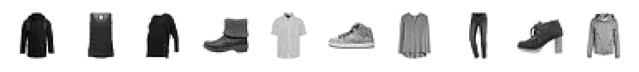

In [3]:
import matplotlib.pyplot as plt


def display(images, n=10, size=(8,6), cmap="gray_r", as_type="float32", save_to=None, style="seaborn-v0_8"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    plt.style.use(style)

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0


    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        img =  images[i]
        plt.imshow(img.astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


samples = next(train_ds.as_numpy_iterator())
display(samples['image'])

# Define the model

In [4]:
dim_latent = 2

In [5]:
import functools as ft

compose = lambda *fs: ft.reduce(lambda f, g: lambda x: g(f(x)), fs)

In [6]:
import jax
from jax import numpy as jnp
from flax import nnx
import typing as tp


class Encoder(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: tp.Callable, rngs: nnx.Rngs):

        self.layers = [

            # -------  CNN  -----------
            # nnx.Conv(in_features=dim_in, out_features=32, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # nnx.Conv(in_features=32, out_features=64, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # nnx.Conv(in_features=64, out_features=128, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # lambda x: x.reshape(x.shape[0], -1),
            # nnx.Linear(in_features=2048, out_features=dim_out, rngs=rngs),
            # -------  END CNN  -----------

            # -------  MLP  -----------
            lambda x: x.reshape(x.shape[0], -1),  # flatten
            nnx.Linear(in_features=dim_in, out_features=512, rngs=rngs),
            activation,
            nnx.Linear(in_features=512, out_features=128, rngs=rngs),
            activation,
            nnx.Linear(in_features=128, out_features=dim_out, rngs=rngs)
            # -------  END MLP  -----------

        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)

In [7]:
import math

encoder = Encoder(dim_in=math.prod(input_shape), dim_out=dim_latent, activation=nnx.relu, rngs=nnx.Rngs(0))
# encoder = Encoder(dim_in=input_shape[-1], dim_out=dim_latent, activation=nnx.relu, rngs=nnx.Rngs(0))

encoder(jnp.ones([1, *input_shape])).shape

W0000 00:00:1736828453.163393 17198741 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736828453.172702 17198741 service.cc:145] XLA service 0x315255b30 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736828453.172710 17198741 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736828453.173918 17198741 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736828453.173929 17198741 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



(1, 2)

In [8]:
class Decoder(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: tp.Callable, rngs: nnx.Rngs):

        self.layers = [

            # -------  CNN  -----------
            # nnx.Linear(in_features=dim_in, out_features=2048, rngs=rngs),
            # lambda x: x.reshape(x.shape[0], 4, 4, 128),
            # activation,
            # nnx.ConvTranspose(in_features=128, out_features=128, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # nnx.ConvTranspose(in_features=128, out_features=64, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # nnx.ConvTranspose(in_features=64, out_features=32, kernel_size=(3,3), strides=(2,2), rngs=rngs),
            # activation,
            # nnx.Conv(in_features=32, out_features=dim_out, kernel_size=(3,3), strides=1, rngs=rngs),
            # -------  END CNN  -----------

            # -------  MLP  -----------
            nnx.Linear(in_features=dim_in, out_features=128, rngs=rngs),
            activation,
            nnx.Linear(in_features=128, out_features=512, rngs=rngs),
            activation,
            nnx.Linear(in_features=512, out_features=dim_out, rngs=rngs),
            # -------  END MLP  -----------

        ]


    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)

In [9]:
import math

decoder = Decoder(dim_in=dim_latent, dim_out=math.prod(input_shape), activation=nnx.relu, rngs=nnx.Rngs(0))
# decoder = Decoder(dim_in=dim_latent, dim_out=input_shape[-1], activation=nnx.relu, rngs=nnx.Rngs(0))

decoder(jnp.ones([1, dim_latent])).shape

(1, 1024)

# AutoEncoder

In [10]:
class AE(nnx.Module):

    def __init__(self,
                 dim_in: int,
                 dim_emb: int,
                 output_shape: tp.Sequence[int],
                 *,
                 activation: tp.Callable,
                 rngs: nnx.Rngs):

        self.encoder = Encoder(dim_in, dim_emb, activation=activation, rngs=rngs)
        self.decoder = Decoder(dim_emb, dim_in, activation=activation, rngs=rngs)
        self.output_shape = output_shape

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def generate(self, x):
        logits = self.decode(x)
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        return nnx.sigmoid(logits)

    def __call__(self, x: jax.Array) -> jax.Array:
        logits = compose(self.encode, self.decode)(x)
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        return logits

In [11]:
model = AE(dim_in=math.prod(input_shape), dim_emb=2, output_shape=input_shape, activation=nnx.tanh, rngs=nnx.Rngs(0))
# model = AE(dim_in=input_shape[-1], dim_emb=2, activation=nnx.tanh, rngs=nnx.Rngs(0))

nnx.display(model)

AE(
  encoder=Encoder(
    layers=[<function Encoder.__init__.<locals>.<lambda> at 0x372b1b9c0>, Linear(
      kernel=Param(
        value=Array(shape=(1024, 512), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(512,), dtype=float32)
      ),
      in_features=1024,
      out_features=512,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x32ae05a80>,
      bias_init=<function zeros at 0x177442ca0>,
      dot_general=<function dot_general at 0x176ddc7c0>
    ), <PjitFunction of <function tanh at 0x17724e520>>, Linear(
      kernel=Param(
        value=Array(shape=(512, 128), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(128,), dtype=float32)
      ),
      in_features=512,
      out_features=128,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<fu

In [12]:
import jax.numpy as jnp

model(jnp.ones([1, math.prod(input_shape)])).shape

# model(jnp.ones([1,  *input_shape])).shape

(1, 32, 32, 1)

# Optimizer

In [13]:
import optax

# lr_schedule = optax.warmup_cosine_decay_schedule(
#     init_value=0.0,
#     peak_value=1e-3,
#     warmup_steps=100,
#     decay_steps=500*len(train_ds),
#     end_value=1e-5
# )
# optimizer = nnx.Optimizer(
#     model,
#     optax.chain(
#         optax.clip(1.0),  # Clip gradients at 1
#         optax.adam(lr_schedule)
#     )``
# )

learning_rate=1e-4
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

metric = nnx.metrics.Average()
nnx.display(metric)

Average(
  argname='values',
  total=MetricState(
    value=Array(0., dtype=float32)
  ),
  count=MetricState(
    value=Array(0, dtype=int32)
  )
)


# Define training steps

In [14]:
def loss_fn(model: AE, batch: jax.Array):
    logits = model(batch["image"])
    loss = jnp.mean(
        optax.sigmoid_binary_cross_entropy(logits, batch["image"])
    )
    return loss

In [15]:
@nnx.jit
def train_step(model: AE, optimizer: nnx.Optimizer, metric: nnx.Metric, batch: jax.Array):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(model, batch)
    metric.update(values=loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model: AE, metric: nnx.Metric, batch: jax.Array):
    loss = loss_fn(model, batch)
    metric.update(values=loss)

# Train and evaluate the model

In [16]:
metric_history = {
    "train_loss": [],
    "test_loss": [],
}

num_steps_per_epoch = train_ds.cardinality() // num_epochs

for step, batch in enumerate(train_ds.as_numpy_iterator(), start=1):

    train_step(model, optimizer, metric, batch)

    if step % num_steps_per_epoch == 0:

        # Log the training metric.
        value = metric.compute()
        metric_history[f"train_loss"].append(value)  # Record the metric.
        metric.reset()  # Reset the metric for the test set.

        # Compute the metric on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metric, test_batch)

        # Log the test metric.
        value = metric.compute()
        metric_history[f'test_loss'].append(value)
        metric.reset()  # Reset the metric for the next training epoch.

        print(
            f"[train] epoch: {step//num_steps_per_epoch}"
        )


        print(
            f"\ttrain loss: {metric_history['train_loss'][-1]:.4f}",
            f"\ttest_loss: {metric_history['test_loss'][-1]:.4f}"
        )


[train] epoch: 1
	train loss: 0.3468 	test_loss: 0.2910
[train] epoch: 2
	train loss: 0.2806 	test_loss: 0.2752
[train] epoch: 3
	train loss: 0.2708 	test_loss: 0.2695
[train] epoch: 4
	train loss: 0.2666 	test_loss: 0.2662
[train] epoch: 5
	train loss: 0.2636 	test_loss: 0.2636
[train] epoch: 6
	train loss: 0.2612 	test_loss: 0.2615
[train] epoch: 7
	train loss: 0.2593 	test_loss: 0.2599
[train] epoch: 8
	train loss: 0.2579 	test_loss: 0.2586
[train] epoch: 9
	train loss: 0.2566 	test_loss: 0.2576
[train] epoch: 10
	train loss: 0.2555 	test_loss: 0.2566
[train] epoch: 11
	train loss: 0.2545 	test_loss: 0.2557
[train] epoch: 12
	train loss: 0.2536 	test_loss: 0.2548
[train] epoch: 13
	train loss: 0.2529 	test_loss: 0.2541
[train] epoch: 14
	train loss: 0.2521 	test_loss: 0.2534
[train] epoch: 15
	train loss: 0.2514 	test_loss: 0.2529
[train] epoch: 16
	train loss: 0.2509 	test_loss: 0.2523
[train] epoch: 17
	train loss: 0.2503 	test_loss: 0.2517
[train] epoch: 18
	train loss: 0.2497 	t

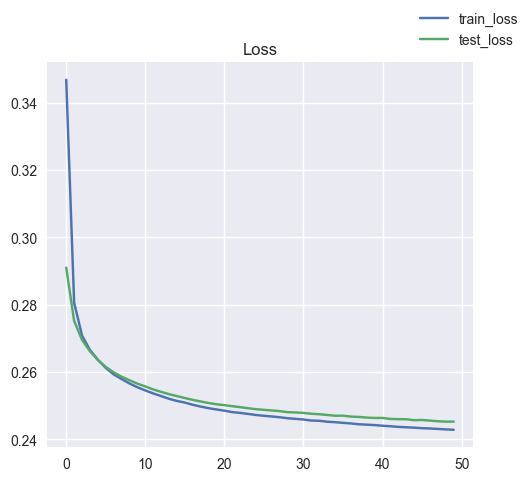

In [17]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig = plt.figure(figsize=(5.5, 5))
plt.title('Loss')
for dataset in ('train', 'test'):
    plt.plot(metric_history[f'{dataset}_loss'], label=f'{dataset}_loss')
fig.legend()
plt.show()

# Reconstruction

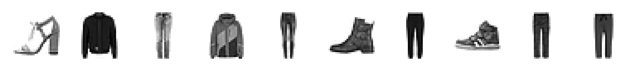

In [18]:
test_examples = test_batch['image']
display(test_examples)

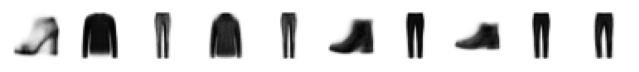

In [19]:
reconstructions = nnx.sigmoid(model(test_examples))
display(reconstructions)

# Visualising the embedding space

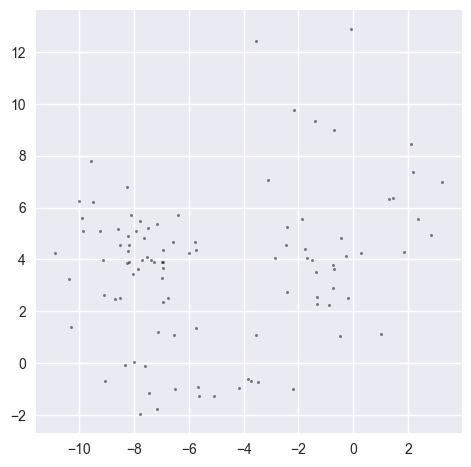

In [20]:
embeddings = model.encode(test_batch["image"])
plt.figure(figsize=(5.5, 5.5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Reconstruction

In [21]:
import numpy as np


def get_samples(ds, num_samples=10):
    example_images = []; example_labels = []
    for i, samples in enumerate(ds.as_numpy_iterator()):
        example_images.append(samples["image"])
        example_labels.append(samples["label"])

        if i*batch_size >= num_samples:
            break
    return np.vstack(example_images)[:n_to_predict], np.hstack(example_labels)[:n_to_predict]

n_to_predict = 5_000
example_images, example_labels = get_samples(test_ds, num_samples=n_to_predict)

embeddings = model.encode(example_images)

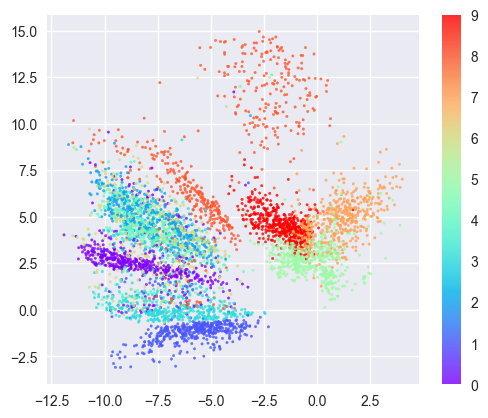

In [22]:
embeddings = model.encode(example_images)

figsize = 6
plt.figure(figsize=(figsize, figsize*0.8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## Generating new images

In [23]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (5, 2)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, dim_latent)
)

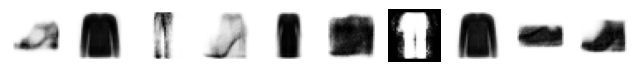

In [24]:
reconstructions = model.generate(sample).reshape(-1, *input_shape)
display(reconstructions)

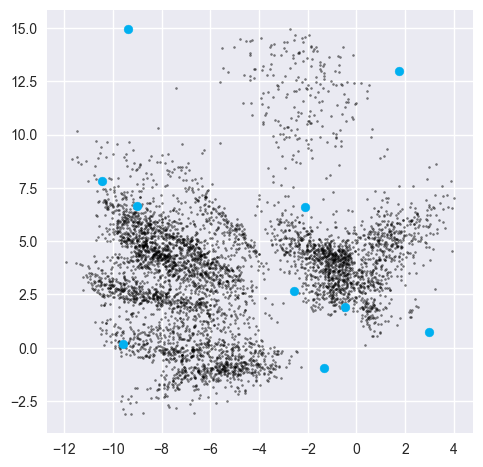

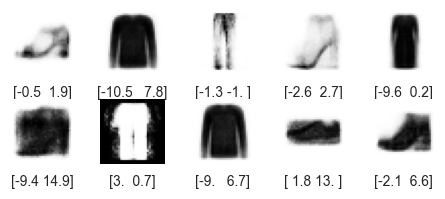

In [25]:
# Draw a plot of...
figsize = 5.5
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")